<a href="https://colab.research.google.com/github/eunseochu/YB_12th/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_%EC%82%B0%ED%83%84%EB%8D%B0%EB%A5%B4_%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%EC%98%88%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **분류 실습 - 캐글 산탄데르 고객 만족 예측**
캐글의 산탄데르 고객 만족(Santander Customer Satisfaction) 데이터 세트에 대해 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측
- 370개의 피처로 주어진 데이트 세트 기반에서 고객 만족 여부 예측
- 클래스 레이블 명: TARGET (1이면 불만을 가진 고객, 0이면 만족한 고객)
- 모델의 성능 평가를 ROC-AUC(ROC 곡선 영역)로 평가

**1) 데이터 전처리**

**1-1) 피처 개수** <br/>
클래스 값 칼럼을 포함한 피처가 371개 존재

In [12]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("/content/sample_data/train_santander.csv",encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


**1-2)  피처의 타입과 Null 값** <br/>
111개의 피처가 float 형, 260개의 피처가 int 형으로 모든 피처가 숫자 형 <br/>
Null 값은 존재하지 않음

In [13]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


**1-3) 전체 데이터에서 만족과 불만족의 비율** <br/>
레이블인 Target 속성의 값의 분포를 알아보면 됨
- 대부분 만족이며, 불만족인 고객은 얼마 되지 않는 4%에 불과

In [14]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


**1-4) 피처의 값 분포 확인** <br/>
var3 칼럼의 경우 min 값이 -99999
- NaN 값이나 특정 예외 값을 -99999로 변환했을 것
- -999999 값은 116개

In [15]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


**1-5) 데이터 변환 및 분리** <br/>
- var3은 숫자형이고, 다른 값에 비해 -999999은 편차가 심하므로 가장 값이 많은 2로 변환
- ID 피처는 단순 식별자에 불과하므로 피처 드롭
- 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 별도 저장

In [16]:
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID', axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


**1-6) 학습 데이터 세트와 테스트 데이터 세트 분리** <br/>
클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출되었는지 확인 (비대칭 데이터)
- 학습과 테스트 데이터 세트 모두 Target 값의 분포가 원본 데이터와 유사
- 전체 데이터의 4% 정도가 불만족 값

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


**2) XGBoost 모델 학습과 하이퍼 파라미터 튜닝** <br/>
XGBoost의 학습 모델의 생성하고 예측 결과를 ROC AUC로 평가
- 사이킷런 래퍼인 XGBClassifier를 기반으로 학습 수행
- n_estimator는 500으로 하되 early_stopping_round를 100으로 설정
- 성능 평가 기준인 eval_metric은 auc로 설정 (logloss도 큰 차이 X)
- 평가 데이터 세트는 테스트 데이터 세트 사용

**2-1) XGBoost 모델 학습** <br/>
테스트 데이터 세트로 예측 시 ROC AUC는 약 0.8419

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

**2-2) XGBoost의 하이퍼 파라미터 튜닝** <br/>
GridSearchCV 적용 후 최적 파라미터를 찾은 뒤, GridSEarchCV에서 재학습된 Estimator에서 ROC-AUC 수치 확인
- 칼럼의 개수가 많으므로 과적합 가능성을 가정하고, max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차 튜닝 대상
 - 학습 시간이 많이 필요한 ML 모델인 경우 2 ~ 3개 정도의 파라미터를 결합해 최적 파라미터를 찾아낸 뒤 최적 파라미터를 기반으로 다시 1 ~ 2개 파라미터를 결합해 파라미터 튜닝을 수행하는 것이 바람직
- 수행 시간이 오래 걸리므로 n_estimator를 100으로 줄이고, early_stopping_rounds도 30으로 줄여서 테스트한 뒤 나중에 하이퍼 파라미터 튜닝이 완료되면 다시 증가
- 하이퍼 파라미터를 적용 시 ROC-AUC가 0.8448로 조금 개선

In [19]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

# cv는 3으로 지정 
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

**2-3) 다른 하이퍼 파라미터를 변경 또는 추가해 최적화 진행** <br/>
GridSearchCV로 구한 최적 하이퍼 파라미터 설정
- 'colsample_bytree: 0.75', 'max_depth: 7', 'min_child_weight: 1'로 설정
- n_estimator를 1000으로 증가시키고, learning_rate는 0.02로 감소
- ROC-AUC가 0.8456으로 이전 테스트보다 살짝 상향된 결과 <br/>

In [22]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,\
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827094	validation_1-auc:0.816566
[2]	validation_0-auc:0.832027	validation_1-auc:0.820393
[3]	validation_0-auc:0.835873	validation_1-auc:0.825019
[4]	validation_0-auc:0.838197	validation_1-auc:0.826078
[5]	validation_0-auc:0.837948	validation_1-auc:0.827282
[6]	validation_0-auc:0.8381	validation_1-auc:0.826888
[7]	validation_0-auc:0.838475	validation_1-auc:0.827131
[8]	validation_0-auc:0.839775	validation_1-auc:0.828198
[9]	validation_0-auc:0.83981	validation_1-auc:0.827834
[10]	validation_0-auc:0.841664	validation_1-auc:0.828996
[11]	validation_0-auc:0.841069	validation_1-auc:0.82802
[12]	validation_0-auc:0.841167	validation_1-auc:0.828517
[13]	validation_0-auc:0.841455	validation_1-auc:0.828317
[14]	validation_0-auc:0.845308	validation_1-auc:0.834099
[1

> **XGBoost의 하이퍼 파라미터 튜닝** <br/>
XGBoost는 GBM보다는 빠르지만 GBM 기반이므로 수행 시간이 많이 요구 되므로, <br/>
하이퍼 파라미터를 다양하게 나열해 파라미터를 튜닝하는 것은 많은 시간 소모
- 앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되지 않음 <br/>
(과적합이나 잡음에 기본적으로 뛰어난 알고리즘이기 때문)
- 일반 PC가 아닌 8코어 이상의 병렬 CPU 코어 시스템을 가진 컴퓨터가 있다면 적극 시도

**2-4) 튜닝된 모델의 피처 중요도 그래프** <br/>
xgboost 모듈의 plot_importance() 메서드 이용
- 예측 성능을 좌우하는 가장 중요한 피처는 var38, var15 순

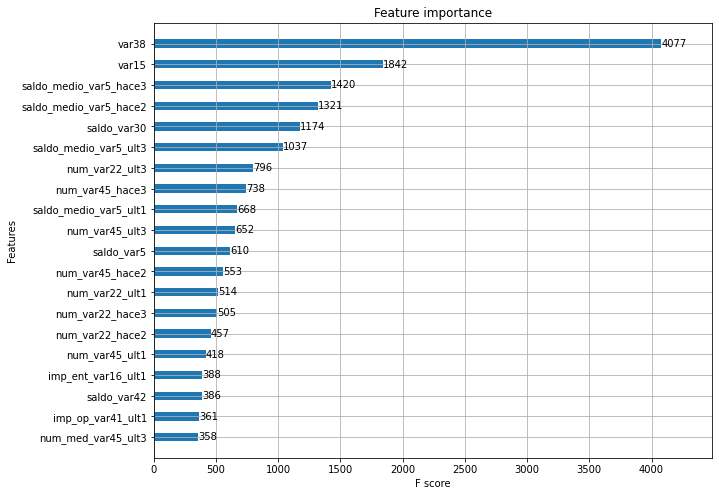

In [23]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

**3) LightGBM 모델 학습과 하이퍼 파라미터 튜닝** <br/>


**3-1) LightGBM 모델 학습**<br/>
LightGBM으로 학습을 수행하고 ROC-AUC 측정
- n_estimator = 500, early_stopping_rounds = 100으로 설정
- 평가 데이터 세트는 테스트 데이터 세트
- eval_metric은 auc 설정
- 수행 결과 ROC AUC는 0.8396
- XGBoost보다 학습에 걸리는 시간이 단축

In [20]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

**3-2) LightGBM의 하이퍼 파라미터 튜닝** <br/>
GridSearchCV로 다양한 하이퍼 파라미터에 대한 튜닝 수행
- 튜닝 대상은 num_leaves, max_depth, min_child_samples, subsample

In [25]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


# cv는 3으로 지정 
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	v

**3-3) 최적 파라미터 재적용 후 ROC-AUC 측정** <br/>
GridSearchCV로 구한 최적 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습 해 ROc-AUC 측정 결과 도출
- ROC-AUC가 0.8442로 측정

In [26]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss

#### **분류 실습 - 캐글 신용카드 사기 검출**
캐글의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습 수행 
- 370개의 피처로 주어진 데이트 세트 기반에서 고객 만족 여부 예측
- 클래스 레이블 명: TARGET (1이면 불만을 가진 고객, 0이면 만족한 고객)
- 모델의 성능 평가를 ROC-AUC(ROC 곡선 영역)로 평가
- 레이블인 Class 속성은 매우 불균형한 분포
 - 0: 사기가 아닌 정상적인 신용카드 트랜잭션 데이터
 - 1: 신용카드 사기 트랜잭션
 - 전체 데이터의 약 0.172%만이 사기 트랜잭션
 - 사기 검출이나 이상 검출과 같은 데이터 세트는 극도로 불균형한 분포 가지기 쉬움

**1) 언더 샘플링과 오버 샘플링의 이해** <br/>
레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제 발생 가능
- 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면, <br/>
정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행하므로 <br/>
제대로 된 이상 데이터 검출이 어려움
- 지도학습에서 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 **적절한 학습 데이터**를 확보하는 방안 필요
 - 오버 샘플링(Oversampling)과 언더 샘플링(Undersampling) 방법
 - 오버 샘플링 방식이 예측 성능상 더 유리

**1-1) 언더 샘플링(Undersampling)** <br/>
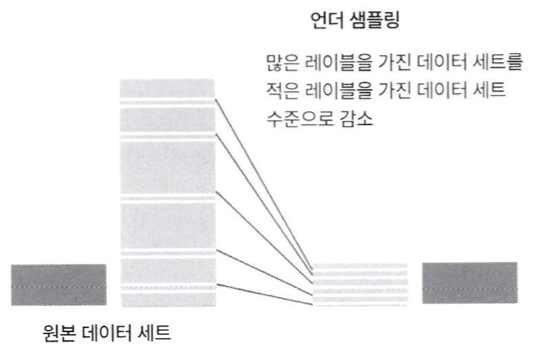

많은 데이터 세트를 **적은 데이터 세트 수준으로 감소**시키는 방식 <br/>
- 과도하게 정상 레이블로 학습/예측하는 부작용 개선
- 너무 많은 정상 레이블 데이터를 감소시키기 때문에, 정상 레이블의 경우 오히려 제대로 학습을 수행할 수 없다는 단점
- 잘 적용하지 않는 방식

**1-2) 오버 샘플링(Oversampling)** <br/>
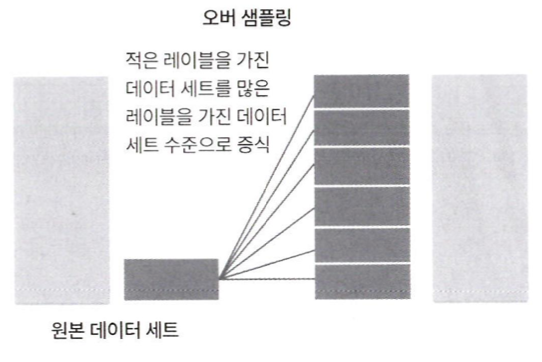

이상 데이터와 같이 **적은 데이터 세트를 증식하여 충분한 데이터를 확보**하는 방법
- 동일한 데이터를 단순히 증식하는 방법은 과적합(Overfitting)이 되기 때문에 의미 X
- 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식
- 대표적으로 **SMOTE** 방법

> **SMOTE(Synthetic Minority Over-sampling Technique)** <br/>
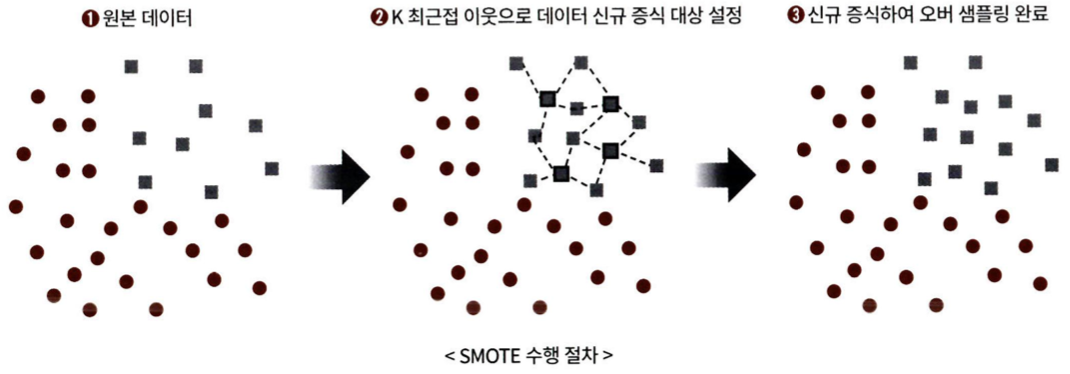
적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K NEarest Neighbor)을 찾아서, <br/>
이 데이터와 K개의 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터 생성
- imbalanced-learn 패키지 이용
>
> ```
> conda install -c conda-forge imbalanced-learn
> ```



**2. 데이터 일차 가공 및 모델 학습/예측/평가** <br/>
데이터 세트를 로딩하고 신용카드 사기 검출 모델 생성

In [28]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/sample_data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [31]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**2-1) 데이터 살펴보기** <br/>
- V로 시작하는 피처들: 의미를 알 수 없음
- Time 피처: 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없으므로 제거
- Amount 피처: 신용카드 트랙잭션 금액
- Class(레이블): 0의 경우 정상, 1의 경우 사기 트랜잭션
- 결측치(Missing Value) 값은 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형

**2-2) 데이터 사전 가공** <br/>
인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 get_preprocessed_df() 함수와 <br/>
데이터 가공 후 학습/테스트 데이터 세트를 반환하는 get_train_test_df() 함수 생성

**2-2-1) get_preprocessed_df()** <br/>
불필요한 Time 피처만 삭제

In [29]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

**2-2-2) get_train_test_dataset()** <br/>
get_preprocessed_df()를 호출한 뒤 **학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트 반환**
- 내부에서 train_test_split() 함수를 호출
- 테스트 데이터 세트를 전체 30%인 Straified 방식으로 추출해, <br/> 
학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만듦 

In [30]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

**2-2-3) 학습/테스트 데이터 레이블 값 비율 확인** <br/>
생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하게 분할됐는지 확인
- 학습 데이터 레이블의 경우 1값이 약 0.172%, 테스트 데이터 레이블의 경우 1값이 약 0.173%로 큰 차이 없이 잘 분할

In [32]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


**2-3) 로지스틱 회귀 모델 생성** <br/>
모델이 데이터 가공을 수행하며 예측 성능이 어떻게 변하는 지 살피기
- 예측 성능 평가는 get_clf_eval() 함수 사용
- 테스트 데이터 세트로 측정 시 재현율(Recall)이 0.6081, ROC-AUC가 0.9709

In [33]:
# get_clf_eval()

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [34]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216,    F1: 0.7244, AUC:0.9609


**2-4) 학습/예측/평가 수행하는 함수 생성** <br/>
반복적으로 모델을 변경해 학습/예측/평가할 것이므로 이를 위한 별도의 함수 get_model_eval() 생성
- 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아 학습/예측/평가 수행하는 함수

In [35]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

**2-4) LightGBM 모델 생성** <br/>
본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로, <br/> 
LGBMClassifier 객체 생성 시 boost_from_average = False로 파라미터를 설정해야 함
- LightGBM으로 모델 학습 후 별도의 테스트 데이터 세트에서 예측 평가 수행
- 재현율 0.7568, ROC-AUC 0.9797로 로지스틱 회귀보다는 높은 수치

> **LightGBM의 boost_from_average** <br/>
본 예제와 같이 레이블 값이 극도로 불균형한 분포를 이루는 경우, <br/>
**boost_from_average = True** 설정은 재현율 및 ROC-AUC 성능을 매우 크게 저하시킴
- LightGBM이 버전업되면서 boost_from_average 파라미터의 디폴트 값이 False에서 True로 변경
- LightGBM 2.1.0 이상의 버전이 설치되어 있거나 불균형한 데이터 세트에서 예측 성능이 매우 저조할 경우, <br/>
 **boost_from_average = False**로 파라미터 설정

In [36]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9797


**3. 데이터 분포도 변환 후 모델 학습/예측/평가** <br/>
왜곡된 분포도를 가지는 데이터를 재가공한 뒤 모델을 다시 테스트

**3-1) 중요 피처 값의 분포도 확인** <br/>
대부분의 선형 모델(로지스틱 회귀)은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호
- Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성 높음
- 카드 사용 금액(Amount)이 1000불 이하인 데이터가 대부분이며, <br/>
27,000까지 드물지만 많은 금액을 사용한 경우가 발생하며 꼬리가 긴 형태의 분포 곡선을 가짐

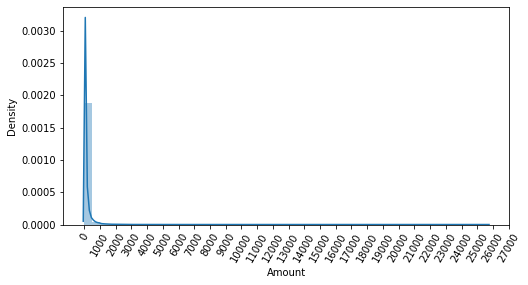

In [37]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

**3-2) 피처를 정규 분포 형태로 변환** <br/>
get_processed_df() 함수를 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경 <br/>
(사이킷런의 StandardScaler 클래스 이용)

In [38]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

**3-3) 로지스틱 회귀와 LightGBM 모델 적용 후 학습/예측/평가 수행** <br/>
get_train_dataset()를 호출해 학습/테스트 데이터 생성 후 get_model_train_eval()를 이용
- 정규 분포 형태로 Amount 피처값을 변환하였으나 변환 이전과 비교해 성능이 크게 개선되지 않음

In [39]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9773


**3-4) 로그 변환 수행** <br/>
로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법
- 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하여 데이터 분포도의 왜곡을 상당 수준 개선
- 넘파이의 log1p() 함수를 이용해 간단히 변환 가능
- 데이터 가공 함수인 get_preprocessed_df()를 로그 변환 로직으로 변경

In [40]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

**3-5) 로지스틱 회귀와 LightGBM 모델 적용 후 학습/예측/평가 수행** <br/>
- 두 모델 모두 정밀도, 재현율, ROC-AUC에서 약간씩 성능 개선

In [43]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9786


**4) 이상치 데이터 제거 후 모델 학습/예측/평가** <br/>
이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
- 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉬움

**4-1) IQR(Inter Quantile Range) 방식** <br/>
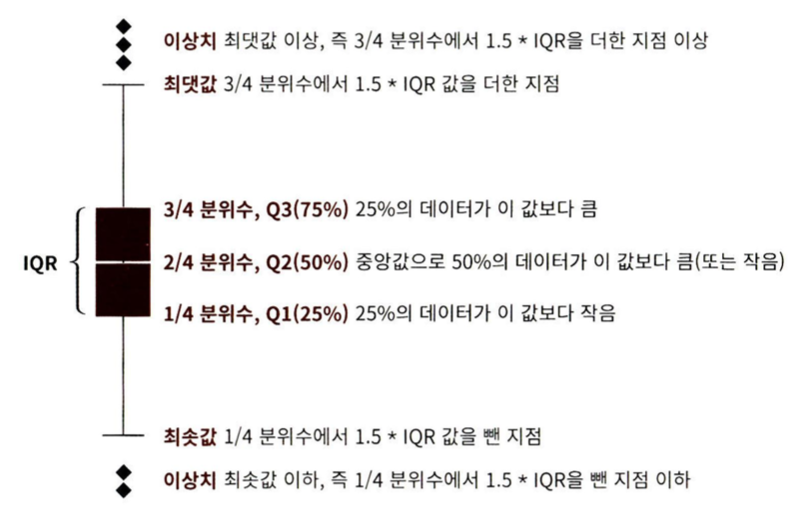

사분위(Quantile) 값의 편차를 이용하는 기법 <br/>
IQR에 1.5를 곱하여 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤, <br/>
**최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치**로 간주
- 3/4 분위수(Q3)에 IQR*1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 가정
- 1/4 분위수(Q1)에 IQR*1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정
- 1.5가 아닌 다른 값을 적용할 수 있으며, 보통은 1.5를 적용
- IQR 방식을 시각화한 도표가 박스 플롯(Box Plot)

> **사분위** <br/>
전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4(25%) 씩 Q1, Q2, Q3, Q4로 구간 분할 <br/>
- 25% 구간인 Q1 ~ 75% 구간인 Q3의 범위를 IQR

**4-2) 이상치 데이터 IQR를 이용해 제거** <br/>
**어떤 피처의 이상치 데이터를 검출할 것인지** 선택 필요 <br/>
- 매우 많은 피처가 있을 경우 이들 중 결정값(즉 레이블)과 가장 상관성이 높은 피처들 위주로 이상치 검출
- 모든 피처들의 이상치를 검출하는 것은 시간이 많이 소모되며, <br/>
결정값과 상관성이 높지 않은 피처들의 경우는 이상치를 제거하더라도 크게 성능 향상에 기여하지 않음

**4-3) 상관관계 히트맵** <br/>
DataFrame의 corr()를 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap을 통해 시각화
- cmap을 'RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, <br/>
음의 상관관계가 높을수록 색갈이 진한 빨간색에 가깝게 표현
- 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17
- V14에 대해서만 이상치를 찾아서 제거

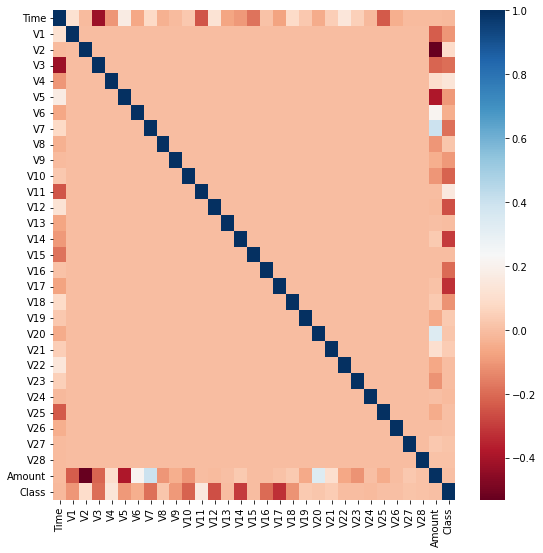

In [44]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu') 

**4-4) 이상치 검출** <br/>
IQR를 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치 삭제
- get_outlier(): 인자로 DataFrame과 이상치를 검출한 칼럼을 입력 받음
- 함수 내에서 넘파이의 percentile()을 이용해 1/4분위와 3/4분위를 구하고, 이에 기반해 IQR 계산
- 계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구한 뒤, <br/>
최댓값보다 크거나 작은 값을 이상치로 설정하고 해당 이상치가 있는 DataFrame Index 반환

In [45]:
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [46]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


**4-5) 이상치 삭제 및 로지스틱 회귀 & LightGBM 모델 적용** <br/>
총 4개의 데이터니 8296, 8615, 9035, 9252번 Index가 이상치로 추출
- get_outlier()를 이용해 이상치를 추출하고 삭제하는 로직을 get_preprocessed_df() 함수에 추가해 데이터 가공
- 데이터 세트를 이용해 로지스틱 회귀와 LightGBM 모델 재적용
- 로지스틱 회귀와 LightGBM 모두 예측 성능 크게 향상 (재현율 크게 증가)

In [47]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,    F1: 0.8930, AUC:0.9831


**5) SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가** <br/>
SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능 평가
- imbalanced-learn 패키지의 SMOTE 클래스로 간단 구현
- 반드시 **학습 데이터 세트**만 오버 샘플링해야 함
- 검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우, <br/> 
결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 아님

**5-1) 데이터 증식** <br/>
학습 피처/레이블 데이터를 SMOTE 객체의 fit_sample() 메서드를 이용해 증식한 뒤, 증식 전과 비교
- 적용 전 학습 데이터 세트는 199,362건이었지만 SMOTE 적용 후 2배에 가까운 398,040으로 증식
- SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020 건으로 생성

In [50]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 페처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 페처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


**5-2) 로지스틱 회귀 모델 학습 및 성능 평가** <br/>
SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만 정밀도가 5.4%로 급격하게 저하
- 재현율이 높더라도 이 정도로 저조한 정밀도는 현실 업무에 적용 불가능
- 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서, <br/>
실제 테스트 데이터 세트에서 예측을 지나치게 Class=1으로 적용해 정밀도가 금격히 떨어짐
- 정밀도와 재현율 곡선을 통해 문제점 확인 필요

In [51]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


**5-3) 정밀도와 재현율 곡선** <br/>
SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인
- precision_recall_curve_plot() 함수 이용
- 임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가, <br/> 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아짐
- 분류 결정 임계값을 조정하더라도 임계값의 민감도가 심해 올바른 재현율/정밀도 성능 얻을 수 없음
- 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못함

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

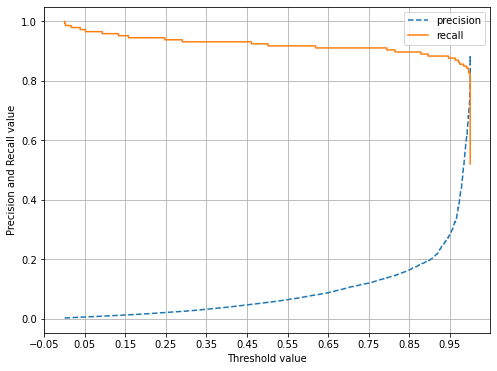

In [55]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

**5-4) LightGBM 모델 학습/예측/평가 수행** <br/>
LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가 수행
- 재현율이 잇아치만 제거한 경우인 82.88%보다 높은 84.93%
- 정밀도는 이전의 96.8%보다 낮은 92.3%
- SMOTE를 적용하면 **재현율은 높아지지만, 정밀도는 낮아지는 것이 일반적**
- 좋은 SMOTE 패키지일수록 재현율 증가율을 높이고 정밀도 감소율을 낮출 수 있도록 효과적으로 데이터 증식

In [56]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493,    F1: 0.8889, AUC:0.9789
